Impact of Governmental Investment Policies in Science and Technology through the Synthetic Diff in Diff

<table align="inner">
  <td>
    <a href="https://github.com/rod53/BrScienceSDID/blob/main/IGERDBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

## SETUP

Check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20. Import the libraries for the analysis. Ensure MatplotLib plots figures inline and prepare a function to save the figures. Set where to save the figures.

In [108]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd
import pycountry
import pycountry_convert as pc
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## GET THE DATA

The datasets used in this study were collected from four different databases, which are described in the following sections. 

_(Note to Prof. Brei: so far have coded only two of the four databases. The other two are SCImago Database (from Elsevier/Scopus) and the World Intelectual Property Organization (WIPO). Both databases extraction are in the process of being coded.)_

### 1. UNESCO Institute of Statistics (UIS)

Free and open access to global demographic, socio-economical data, used as covariate in the SCM ans SDID. Available in http://data.uis.unesco.org/.

In [109]:
#Import data from github for each dataset in UIS
APOPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/APOP.csv"
APOPdf = pd.read_csv(APOPurl, sep=";", encoding="latin-1")

GDPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDP.csv"
GDPdf = pd.read_csv(GDPurl, sep=";", encoding="latin-1")

GDPPCurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDPPC.csv"
GDPPCdf = pd.read_csv(GDPPCurl, sep=";", encoding="latin-1")

GETEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GETE.csv"
GETEdf = pd.read_csv(GETEurl, sep=";", encoding="latin-1")

GERDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GERD.csv"
GERDdf = pd.read_csv(GERDurl, sep=";", encoding="latin-1")

RPMIurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/RPMI.csv"
RPMIdf = pd.read_csv(RPMIurl, sep=";", encoding="latin-1")

In [110]:
# The datasets include other variables on the same file, this code aims to leave only the desired rows
APOPdf = APOPdf[APOPdf['Indicator'] == "Population aged 25-64 years (thousands) "]
GDPdf = GDPdf[GDPdf['Indicator'] == "GDP, PPP (constant 2011 international $)"]
GDPPCdf = GDPPCdf[GDPPCdf['Indicator'] == "GDP per capita, PPP (constant 2011 international $)"]
GETEdf = GETEdf[GETEdf['Indicator'] == "Government expenditure on tertiary education as a percentage of GDP (%)"]
GERDdf = GERDdf[GERDdf['Indicator'] == "GERD as a percentage of GDP"]
RPMIdf = RPMIdf[RPMIdf['Indicator'] == "Researchers per million inhabitants (FTE)"]

In [111]:
# Sort by Code and Year
APOPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPPCdf.sort_values(by=['Code', 'Year'], inplace=True)
GETEdf.sort_values(by=['Code', 'Year'], inplace=True)
GERDdf.sort_values(by=['Code', 'Year'], inplace=True)
RPMIdf.sort_values(by=['Code', 'Year'], inplace=True)

In [112]:
# Leave only the columns of interest
APOPdf = APOPdf[['Code', 'Year', 'Value']]
GDPdf = GDPdf[['Code', 'Year', 'Value']]
GDPPCdf = GDPPCdf[['Code', 'Year', 'Value']]
GETEdf = GETEdf[['Code', 'Year', 'Value']]
GERDdf = GERDdf[['Code', 'Year', 'Value']]
RPMIdf = RPMIdf[['Code', 'Year', 'Value']]

In [113]:
# Rename the columns with name of the indicator
APOPdf.rename(columns={'Value': 'APOP'}, inplace=True)
GDPdf.rename(columns={'Value': 'GDP'}, inplace=True)
GDPPCdf.rename(columns={'Value': 'GDPPC'}, inplace=True)
GETEdf.rename(columns={'Value': 'GETE'}, inplace=True)
GERDdf.rename(columns={'Value': 'GERD'}, inplace=True)
RPMIdf.rename(columns={'Value': 'RPMI'}, inplace=True)

In [114]:
# sum how many countries appear 22 times in each dataframe
print((APOPdf['Code'].value_counts() == 22).value_counts())
print((GDPdf['Code'].value_counts() == 22).value_counts())
print((GDPPCdf['Code'].value_counts() == 22).value_counts())
print((GETEdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((GERDdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((RPMIdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data

True     213
False     17
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
False    177
True       7
Name: Code, dtype: int64
False    180
True       4
Name: Code, dtype: int64
False    173
True       2
Name: Code, dtype: int64


### 2. InCites - Clarivates (IC)

InCites is a paid-access platform from Clarivates, the same group as the Web of Science (WoS), that provides access to multiple databases of reference and citation data from academic journals, conference proceedings, and other documents in various academic disciplines. Available on https://incites.clarivate.com/.

In [115]:
#Import data from github for each dataset in IC
IC2000url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2000IncitesLocations.csv"
IC2000df = pd.read_csv(IC2000url, sep=";", encoding="latin-1")
IC2001url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2001IncitesLocations.csv"
IC2001df = pd.read_csv(IC2001url, sep=";", encoding="latin-1")
IC2002url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2002IncitesLocations.csv"
IC2002df = pd.read_csv(IC2002url, sep=",", encoding="latin-1")
IC2003url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2003IncitesLocations.csv"
IC2003df = pd.read_csv(IC2003url, sep=",", encoding="latin-1")
IC2004url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2004IncitesLocations.csv"
IC2004df = pd.read_csv(IC2004url, sep=",", encoding="latin-1")
IC2005url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2005IncitesLocations.csv"
IC2005df = pd.read_csv(IC2005url, sep=",", encoding="latin-1")
IC2006url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2006IncitesLocations.csv"
IC2006df = pd.read_csv(IC2006url, sep=",", encoding="latin-1")
IC2007url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2007IncitesLocations.csv"
IC2007df = pd.read_csv(IC2007url, sep=",", encoding="latin-1")
IC2008url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2008IncitesLocations.csv"
IC2008df = pd.read_csv(IC2008url, sep=",", encoding="latin-1")
IC2009url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2009IncitesLocations.csv"
IC2009df = pd.read_csv(IC2009url, sep=",", encoding="latin-1")
IC2010url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2010IncitesLocations.csv"
IC2010df = pd.read_csv(IC2010url, sep=",", encoding="latin-1")
IC2011url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2011IncitesLocations.csv"
IC2011df = pd.read_csv(IC2011url, sep=",", encoding="latin-1")
IC2012url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2012IncitesLocations.csv"
IC2012df = pd.read_csv(IC2012url, sep=",", encoding="latin-1")
IC2013url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2013IncitesLocations.csv"
IC2013df = pd.read_csv(IC2013url, sep=",", encoding="latin-1")
IC2014url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2014IncitesLocations.csv"
IC2014df = pd.read_csv(IC2014url, sep=",", encoding="latin-1")
IC2015url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2015IncitesLocations.csv"
IC2015df = pd.read_csv(IC2015url, sep=",", encoding="latin-1")
IC2016url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2016IncitesLocations.csv"
IC2016df = pd.read_csv(IC2016url, sep=",", encoding="latin-1")
IC2017url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2017IncitesLocations.csv"
IC2017df = pd.read_csv(IC2017url, sep=",", encoding="latin-1")
IC2018url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2018IncitesLocations.csv"
IC2018df = pd.read_csv(IC2018url, sep=",", encoding="latin-1")
IC2019url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2019IncitesLocations.csv"
IC2019df = pd.read_csv(IC2019url, sep=",", encoding="latin-1")
IC2020url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2020IncitesLocations.csv"
IC2020df = pd.read_csv(IC2020url, sep=",", encoding="latin-1")
IC2021url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2021IncitesLocations.csv"
IC2021df = pd.read_csv(IC2021url, sep=",", encoding="latin-1")

In [116]:
IC2000df

,ï»¿Name,Web of Science Documents,Times Cited,Rank,% Docs Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,% First Author (2008-2022),% Global Baseline (Docs),...,% Documents in Q3 Journals,% Green Submitted Documents,% Documents in Q4 Journals,% Green Accepted Documents,% Green Published Documents,Documents in Top 1%,Documents in Top 10%,% Green Only Documents,Hot Papers,% Non-Open Access Documents
0,Global Baseline,1348891,35800053.0,NaN,65.84,0.986064,147694.0,152555.0,NaN,100.000000,...,16.02,2.91,14.08,0.32,3.28,16204.0,132442.0,4.06,0.0,88.69
1,Baseline for All Items,1168409,35591771.0,NaN,73.65,1.050718,147694.0,148532.0,NaN,NaN,...,15.98,3.32,11.67,0.36,3.73,15048.0,125778.0,4.62,0.0,87.29
2,USA,435823,17265962.0,1.0,70.54,1.353955,67767.0,60026.0,0.0,32.309727,...,12.43,3.46,6.95,0.43,4.30,8319.0,61385.0,5.30,0.0,86.23
3,UNITED KINGDOM,116683,4239808.0,2.0,72.80,1.227118,28657.0,18903.0,0.0,8.650291,...,13.15,3.60,7.52,1.00,5.94,1898.0,14668.0,5.55,0.0,83.80
4,ENGLAND,99285,3682421.0,3.0,72.97,1.242332,24519.0,16312.0,0.0,7.360491,...,12.96,3.71,7.46,0.97,6.10,1648.0,12727.0,5.67,0.0,83.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Location Type: Country/Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,Domestic/International Collaboration: All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,Exported date Sep 13,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# Add a new line in the beginning of each dataset with the year
IC2000df.insert(0, 'Year', '2000')
IC2001df.insert(0, 'Year', '2001')
IC2002df.insert(0, 'Year', '2002')
IC2003df.insert(0, 'Year', '2003')
IC2004df.insert(0, 'Year', '2004')
IC2005df.insert(0, 'Year', '2005')
IC2006df.insert(0, 'Year', '2006')
IC2007df.insert(0, 'Year', '2007')
IC2008df.insert(0, 'Year', '2008')
IC2009df.insert(0, 'Year', '2009')
IC2010df.insert(0, 'Year', '2010')
IC2011df.insert(0, 'Year', '2011')
IC2012df.insert(0, 'Year', '2012')
IC2013df.insert(0, 'Year', '2013')
IC2014df.insert(0, 'Year', '2014')
IC2015df.insert(0, 'Year', '2015')
IC2016df.insert(0, 'Year', '2016')
IC2017df.insert(0, 'Year', '2017')
IC2018df.insert(0, 'Year', '2018')
IC2019df.insert(0, 'Year', '2019')
IC2020df.insert(0, 'Year', '2020')
IC2021df.insert(0, 'Year', '2021')

In [118]:
# Rename the second column to "Name"
IC2000df.rename(columns={IC2000df.columns[1]: "Name"}, inplace=True)
IC2001df.rename(columns={IC2001df.columns[1]: "Name"}, inplace=True)
IC2002df.rename(columns={IC2002df.columns[1]: "Name"}, inplace=True)
IC2003df.rename(columns={IC2003df.columns[1]: "Name"}, inplace=True)
IC2004df.rename(columns={IC2004df.columns[1]: "Name"}, inplace=True)
IC2005df.rename(columns={IC2005df.columns[1]: "Name"}, inplace=True)
IC2006df.rename(columns={IC2006df.columns[1]: "Name"}, inplace=True)
IC2007df.rename(columns={IC2007df.columns[1]: "Name"}, inplace=True)
IC2008df.rename(columns={IC2008df.columns[1]: "Name"}, inplace=True)
IC2009df.rename(columns={IC2009df.columns[1]: "Name"}, inplace=True)
IC2010df.rename(columns={IC2010df.columns[1]: "Name"}, inplace=True)
IC2011df.rename(columns={IC2011df.columns[1]: "Name"}, inplace=True)
IC2012df.rename(columns={IC2012df.columns[1]: "Name"}, inplace=True)
IC2013df.rename(columns={IC2013df.columns[1]: "Name"}, inplace=True)
IC2014df.rename(columns={IC2014df.columns[1]: "Name"}, inplace=True)
IC2015df.rename(columns={IC2015df.columns[1]: "Name"}, inplace=True)
IC2016df.rename(columns={IC2016df.columns[1]: "Name"}, inplace=True)
IC2017df.rename(columns={IC2017df.columns[1]: "Name"}, inplace=True)
IC2018df.rename(columns={IC2018df.columns[1]: "Name"}, inplace=True)
IC2019df.rename(columns={IC2019df.columns[1]: "Name"}, inplace=True)
IC2020df.rename(columns={IC2020df.columns[1]: "Name"}, inplace=True)
IC2021df.rename(columns={IC2021df.columns[1]: "Name"}, inplace=True)

In [119]:
# Import csv from https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv
CODEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv"
CODEdf = pd.read_csv(CODEurl, sep=";", encoding="latin-1")
CODEdf.head()

,Name,Code,Len
0,ARUBA,ABW,5
1,AFGHANISTAN,AFG,11
2,ISLAMIC STATE OF AFGHANISTAN,AFG,28
3,ANGOLA,AGO,6
4,PEOPLE'S REPUBLIC OF ANGOLA,AGO,27


In [120]:
# Create a new column with the country code
IC2000df['Code'] = IC2000df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2001df['Code'] = IC2001df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2002df['Code'] = IC2002df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2003df['Code'] = IC2003df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2004df['Code'] = IC2004df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2005df['Code'] = IC2005df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2006df['Code'] = IC2006df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2007df['Code'] = IC2007df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2008df['Code'] = IC2008df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2009df['Code'] = IC2009df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2010df['Code'] = IC2010df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2011df['Code'] = IC2011df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2012df['Code'] = IC2012df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2013df['Code'] = IC2013df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2014df['Code'] = IC2014df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2015df['Code'] = IC2015df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2016df['Code'] = IC2016df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2017df['Code'] = IC2017df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2018df['Code'] = IC2018df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2019df['Code'] = IC2019df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2020df['Code'] = IC2020df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2021df['Code'] = IC2021df['Name'].map(CODEdf.set_index('Name')['Code'])

In [121]:
# Merge all dataframes
ICdf = pd.concat([IC2000df, IC2001df, IC2002df, IC2003df, IC2004df, IC2005df, IC2006df, IC2007df, IC2008df, IC2009df, IC2010df, IC2011df, IC2012df, IC2013df, IC2014df, IC2015df, IC2016df, IC2017df, IC2018df, IC2019df, IC2020df, IC2021df], ignore_index=True)
ICdf['Year']=ICdf['Year'].astype(int) # Convert year to integer, to be able to merge to other tables

# Convert Web of Science to numeric 
ICdf['Web of Science Documents'] = pd.to_numeric(ICdf['Web of Science Documents'], errors='coerce')

ICdf.head()

,Year,Name,Web of Science Documents,Times Cited,Rank,% Docs Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,% First Author (2008-2022),...,% Green Submitted Documents,% Documents in Q4 Journals,% Green Accepted Documents,% Green Published Documents,Documents in Top 1%,Documents in Top 10%,% Green Only Documents,Hot Papers,% Non-Open Access Documents,Code
0,2000,Global Baseline,1348891.0,35800053.0,NaN,65.84,0.986064,147694.0,152555.0,NaN,...,2.91,14.08,0.32,3.28,16204.0,132442.0,4.06,0.0,88.69,NaN
1,2000,Baseline for All Items,1168409.0,35591771.0,NaN,73.65,1.050718,147694.0,148532.0,NaN,...,3.32,11.67,0.36,3.73,15048.0,125778.0,4.62,0.0,87.29,NaN
2,2000,USA,435823.0,17265962.0,1.0,70.54,1.353955,67767.0,60026.0,0.0,...,3.46,6.95,0.43,4.30,8319.0,61385.0,5.30,0.0,86.23,USA
3,2000,UNITED KINGDOM,116683.0,4239808.0,2.0,72.80,1.227118,28657.0,18903.0,0.0,...,3.60,7.52,1.00,5.94,1898.0,14668.0,5.55,0.0,83.80,GBR
4,2000,ENGLAND,99285.0,3682421.0,3.0,72.97,1.242332,24519.0,16312.0,0.0,...,3.71,7.46,0.97,6.10,1648.0,12727.0,5.67,0.0,83.57,NaN


## CONSOLIDATE DATA

This section aims to consolidate the data from the different sources, in order to create a single dataset with all the information needed for the analysis.

In [122]:
# Import ID to be used to find the Codes for IC data
IDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/ID.csv"
IDdf = pd.read_csv(IDurl, sep=";", encoding="latin-1")
#rename the first column to "Name"
IDdf.rename(columns={IDdf.columns[0]: "Name"}, inplace=True)
# Leave only one name for each country
IDdf.drop(IDdf.columns[[1,2,3]], axis=1, inplace=True)
IDdf.head()

,Name,Code,Region,Income Group
0,Afghanistan,AFG,South Asia,Low income
1,Albania,ALB,Europe & Central Asia,Upper middle income
2,Algeria,DZA,Middle East & North Africa,Upper middle income
3,American Samoa,ASM,East Asia & Pacific,Upper middle income
4,Andorra,AND,Europe & Central Asia,High income: nonOECD


In [123]:
# Create a list of countries to be used in the analysis
# DB = pd.concat([IDdf]*22, ignore_index=True)
DB = IDdf.copy()
DB['Year'] = [2000]*213
for i in range(2001, 2022):
    DBappend = IDdf.copy()
    DBappend['Year'] = [i]*213
    DB = DB.append(DBappend, ignore_index=True)
DB

C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\3064996866.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DB = DB.append(DBappend, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\3064996866.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DB = DB.append(DBappend, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\3064996866.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DB = DB.append(DBappend, ignore_index=True)
C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\3064996866.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DB = DB.append(DBappend, ignore_index=True)
C:\Users\rodri\A

,Name,Code,Region,Income Group,Year
0,Afghanistan,AFG,South Asia,Low income,2000
1,Albania,ALB,Europe & Central Asia,Upper middle income,2000
2,Algeria,DZA,Middle East & North Africa,Upper middle income,2000
3,American Samoa,ASM,East Asia & Pacific,Upper middle income,2000
4,Andorra,AND,Europe & Central Asia,High income: nonOECD,2000
...,...,...,...,...,...
4681,Virgin Islands,VIR,Latin America & Caribbean,High income: nonOECD,2021
4682,West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income,2021
4683,Yemen,YEM,Middle East & North Africa,Lower middle income,2021
4684,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,2021


In [124]:
#Join all datasets in one
df = pd.merge(DB, APOPdf, on=['Code', 'Year'], how='outer', suffixes= ('', '_y'))
df = pd.merge(df, GDPdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GDPPCdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GETEdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GERDdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, RPMIdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, ICdf, on=['Code', 'Year'], how='outer')

#Sort by Code and Year
df.sort_values(by=['Code', 'Year'], inplace=True)

# Rename column "Name_x" to "Country"
df.rename(columns={'Name_x': 'Country'}, inplace=True)

# Drop coloumn "Name_y"
df.drop('Name_y', axis=1, inplace=True)

# Drop coloumn "Location Type"
df.drop('Location Type', axis=1, inplace=True)

# Drop columns which the label start with "%"
df = df.loc[:, ~df.columns.str.startswith('%')]

#Drop rows with missing values in Country
df.dropna(subset=['Country'], inplace=True)

## FIRST LOOK AT THE DATA

This section aims to get a first look at the data, in order to understand the structure of the dataset and the variables that will be used in the analysis.

In [125]:
# Count how many countries show up in df
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

213
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4686 entries, 9 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4686 non-null   object 
 1   Code                                 4686 non-null   object 
 2   Region                               4642 non-null   object 
 3   Income Group                         4642 non-null   object 
 4   Year                                 4686 non-null   int64  
 5   APOP                                 4510 non-null   float64
 6   GDP                                  4168 non-null   float64
 7   GDPPC                                4168 non-null   float64
 8   GETE                                 1815 non-null   float64
 9   GERD                                 1891 non-null   float64
 10  RPMI                                 1492 non-null   float64
 11  Web of Science Documents  

Country                                 0.000000
Code                                    0.000000
Region                                  0.938967
Income Group                            0.938967
Year                                    0.000000
APOP                                    3.755869
GDP                                    11.054204
GDPPC                                  11.054204
GETE                                   61.267606
GERD                                   59.645753
RPMI                                   68.160478
Web of Science Documents                8.557405
Times Cited                             8.557405
Rank                                    8.557405
Category Normalized Citation Impact     8.557405
International Collaborations            8.557405
All Open Access Documents               8.557405
Gold Documents                          8.557405
Citation Impact                         8.557405
Gold - Hybrid Documents                 8.557405
Average Percentile  

## CLEANING MISSING DATA

This section aims to clean the data, in order to remove the missing values.

The approach used is to remove the missing values was the interpolation of the missing values with the mean of the values of the adjacent years. The interpolation with the mean of the values of the adjacent years is a good approximation of the value of the year in question.

_(Note to Prof. Brei: Regarding the outliers, I will not remove them, because they may contribute to the analysis. Both SCM and SDID are tolerant to atypical values.)_

In [126]:
# Interpolate missing values for each Country, using values from previous and next years
df['APOP'] = df.groupby('Country')['APOP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GDP'] = df.groupby('Country')['GDP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GDPPC'] = df.groupby('Country')['GDPPC'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GETE'] = df.groupby('Country')['GETE'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['GERD'] = df.groupby('Country')['GERD'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['RPMI'] = df.groupby('Country')['RPMI'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Web of Science Documents'] = df.groupby('Country')['Web of Science Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Times Cited'] = df.groupby('Country')['Times Cited'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Rank'] = df.groupby('Country')['Rank'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Category Normalized Citation Impact'] = df.groupby('Country')['Category Normalized Citation Impact'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['International Collaborations'] = df.groupby('Country')['International Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['All Open Access Documents'] = df.groupby('Country')['All Open Access Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Gold Documents'] = df.groupby('Country')['Gold Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Citation Impact'] = df.groupby('Country')['Citation Impact'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Gold - Hybrid Documents'] = df.groupby('Country')['Gold - Hybrid Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Average Percentile'] = df.groupby('Country')['Average Percentile'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Free to Read Documents'] = df.groupby('Country')['Free to Read Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['First Author (2008-2022)'] = df.groupby('Country')['First Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Industry Collaborations'] = df.groupby('Country')['Industry Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Highly Cited Papers'] = df.groupby('Country')['Highly Cited Papers'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Impact Relative to World'] = df.groupby('Country')['Impact Relative to World'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Last Author (2008-2022)'] = df.groupby('Country')['Last Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Domestic Collaborations'] = df.groupby('Country')['Domestic Collaborations'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Submitted Documents'] = df.groupby('Country')['Green Submitted Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Accepted Documents'] = df.groupby('Country')['Green Accepted Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Corresponding Author (2008-2022)'] = df.groupby('Country')['Corresponding Author (2008-2022)'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in JIF Journals'] = df.groupby('Country')['Documents in JIF Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Published Documents'] = df.groupby('Country')['Green Published Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q1 Journals'] = df.groupby('Country')['Documents in Q1 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Green Only Documents'] = df.groupby('Country')['Green Only Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Citations From Patents'] = df.groupby('Country')['Citations From Patents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q2 Journals'] = df.groupby('Country')['Documents in Q2 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Non-Open Access Documents'] = df.groupby('Country')['Non-Open Access Documents'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q3 Journals'] = df.groupby('Country')['Documents in Q3 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Q4 Journals'] = df.groupby('Country')['Documents in Q4 Journals'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Top 1%'] = df.groupby('Country')['Documents in Top 1%'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Documents in Top 10%'] = df.groupby('Country')['Documents in Top 10%'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
df['Hot Papers'] = df.groupby('Country')['Hot Papers'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\994967600.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['APOP'] = df.groupby('Country')['APOP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\994967600.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, u

In [127]:
# Drop rows with missing values in the columns APOP, GDP or Web of Science Documents
df = df.dropna(subset=['APOP', 'GDP', 'Web of Science Documents'])

In [128]:
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

185
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents  

Country                                 0.000000
Code                                    0.000000
Region                                  0.540541
Income Group                            0.540541
Year                                    0.000000
APOP                                    0.000000
GDP                                     0.000000
GDPPC                                   0.000000
GETE                                   11.351351
GERD                                   25.405405
RPMI                                   29.729730
Web of Science Documents                0.000000
Times Cited                             0.000000
Rank                                    0.000000
Category Normalized Citation Impact     0.000000
International Collaborations            0.000000
All Open Access Documents               0.000000
Gold Documents                          0.000000
Citation Impact                         0.000000
Gold - Hybrid Documents                 0.000000
Average Percentile  

In [129]:
# Drop countries with less than 22 observations
df = df.groupby('Country').filter(lambda x: len(x) > 21)

## DISCOVER AND VISUALIZE THE DATA TO GAIN INSIGHTS

The main objective of this sections is to understand the data and to identify its main characteristics. 

In [130]:
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

185
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents  

Country                                 0.000000
Code                                    0.000000
Region                                  0.540541
Income Group                            0.540541
Year                                    0.000000
APOP                                    0.000000
GDP                                     0.000000
GDPPC                                   0.000000
GETE                                   11.351351
GERD                                   25.405405
RPMI                                   29.729730
Web of Science Documents                0.000000
Times Cited                             0.000000
Rank                                    0.000000
Category Normalized Citation Impact     0.000000
International Collaborations            0.000000
All Open Access Documents               0.000000
Gold Documents                          0.000000
Citation Impact                         0.000000
Gold - Hybrid Documents                 0.000000
Average Percentile  

In [131]:
df.head()

,Country,Code,Region,Income Group,Year,APOP,GDP,GDPPC,GETE,GERD,...,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%,Hot Papers
0,Afghanistan,AFG,South Asia,Low income,2000,6197.0,2.689005e+10,1190.0,0.31427,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
213,Afghanistan,AFG,South Asia,Low income,2001,6420.0,2.689005e+10,1190.0,0.31427,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
426,Afghanistan,AFG,South Asia,Low income,2002,6711.0,2.689005e+10,1190.0,0.31427,NaN,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
639,Afghanistan,AFG,South Asia,Low income,2003,7042.0,2.926506e+10,1236.0,0.31427,NaN,...,9.0,0.0,16.0,1.0,11.0,1.0,0.0,0.0,3.0,0.0
852,Afghanistan,AFG,South Asia,Low income,2004,7381.0,2.967890e+10,1200.0,0.31427,NaN,...,6.0,1.0,0.0,4.0,10.0,0.0,1.0,0.0,1.0,0.0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents      

In [133]:
df.describe()

,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Rank,...,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%,Hot Papers
count,4070.000000,4070.000000,4.070000e+03,4070.000000,3608.000000,3036.000000,2860.000000,4070.000000,4.070000e+03,4070.000000,...,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,2010.500000,17783.050246,5.292412e+11,19322.161179,0.860796,0.737341,1397.251278,15085.687961,3.041621e+05,103.099631,...,5691.900491,1500.020762,2487.373464,2787.109337,10176.215233,1638.804914,1161.005774,244.086486,1809.061916,2.682801
std,6.345068,72609.261413,1.833655e+12,21538.178961,0.555418,0.886174,1861.668934,60170.436492,1.351708e+06,60.030986,...,25754.750707,7113.634133,17064.097869,11242.482982,40640.639916,6153.311793,3838.404002,1088.463489,7911.040665,29.116960
min,2000.000000,4.000000,3.278146e+07,631.000000,0.059390,0.005440,5.911830,1.000000,0.000000e+00,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,707.750000,1.464772e+10,3962.750000,0.413040,0.154120,79.423952,64.000000,1.122500e+03,51.000000,...,20.000000,4.000000,0.000000,12.000000,41.000000,8.000000,6.000000,1.000000,6.000000,0.000000
50%,2010.500000,3139.500000,5.616402e+10,11344.500000,0.789000,0.372975,475.083124,467.000000,7.890000e+03,101.000000,...,134.000000,33.000000,13.000000,83.000000,294.500000,56.000000,46.500000,5.000000,40.500000,0.000000
75%,2016.000000,9928.750000,3.180000e+11,27484.000000,1.143333,0.936878,2023.266260,5722.250000,7.381250e+04,155.000000,...,1375.750000,355.000000,204.000000,960.250000,4140.000000,700.000000,579.500000,65.000000,492.000000,0.000000
max,2021.000000,843081.000000,2.490000e+13,161971.000000,4.485930,5.435620,8713.593830,848951.000000,1.935112e+07,212.000000,...,382692.000000,111355.000000,339608.000000,190173.000000,495009.000000,97934.000000,53367.000000,16197.000000,112441.000000,943.000000


*Histograms Insights*

Most of the variables have a huge concentration of values in the lower range, with a long tail. This pictures how most of indicators of scientific production are highly concentrated in a few countries, while the rest of the countries have a very low production.

Based on the histograms the column 'Rank' was dropped, since it is incomplete due to the countries previous exclusions.

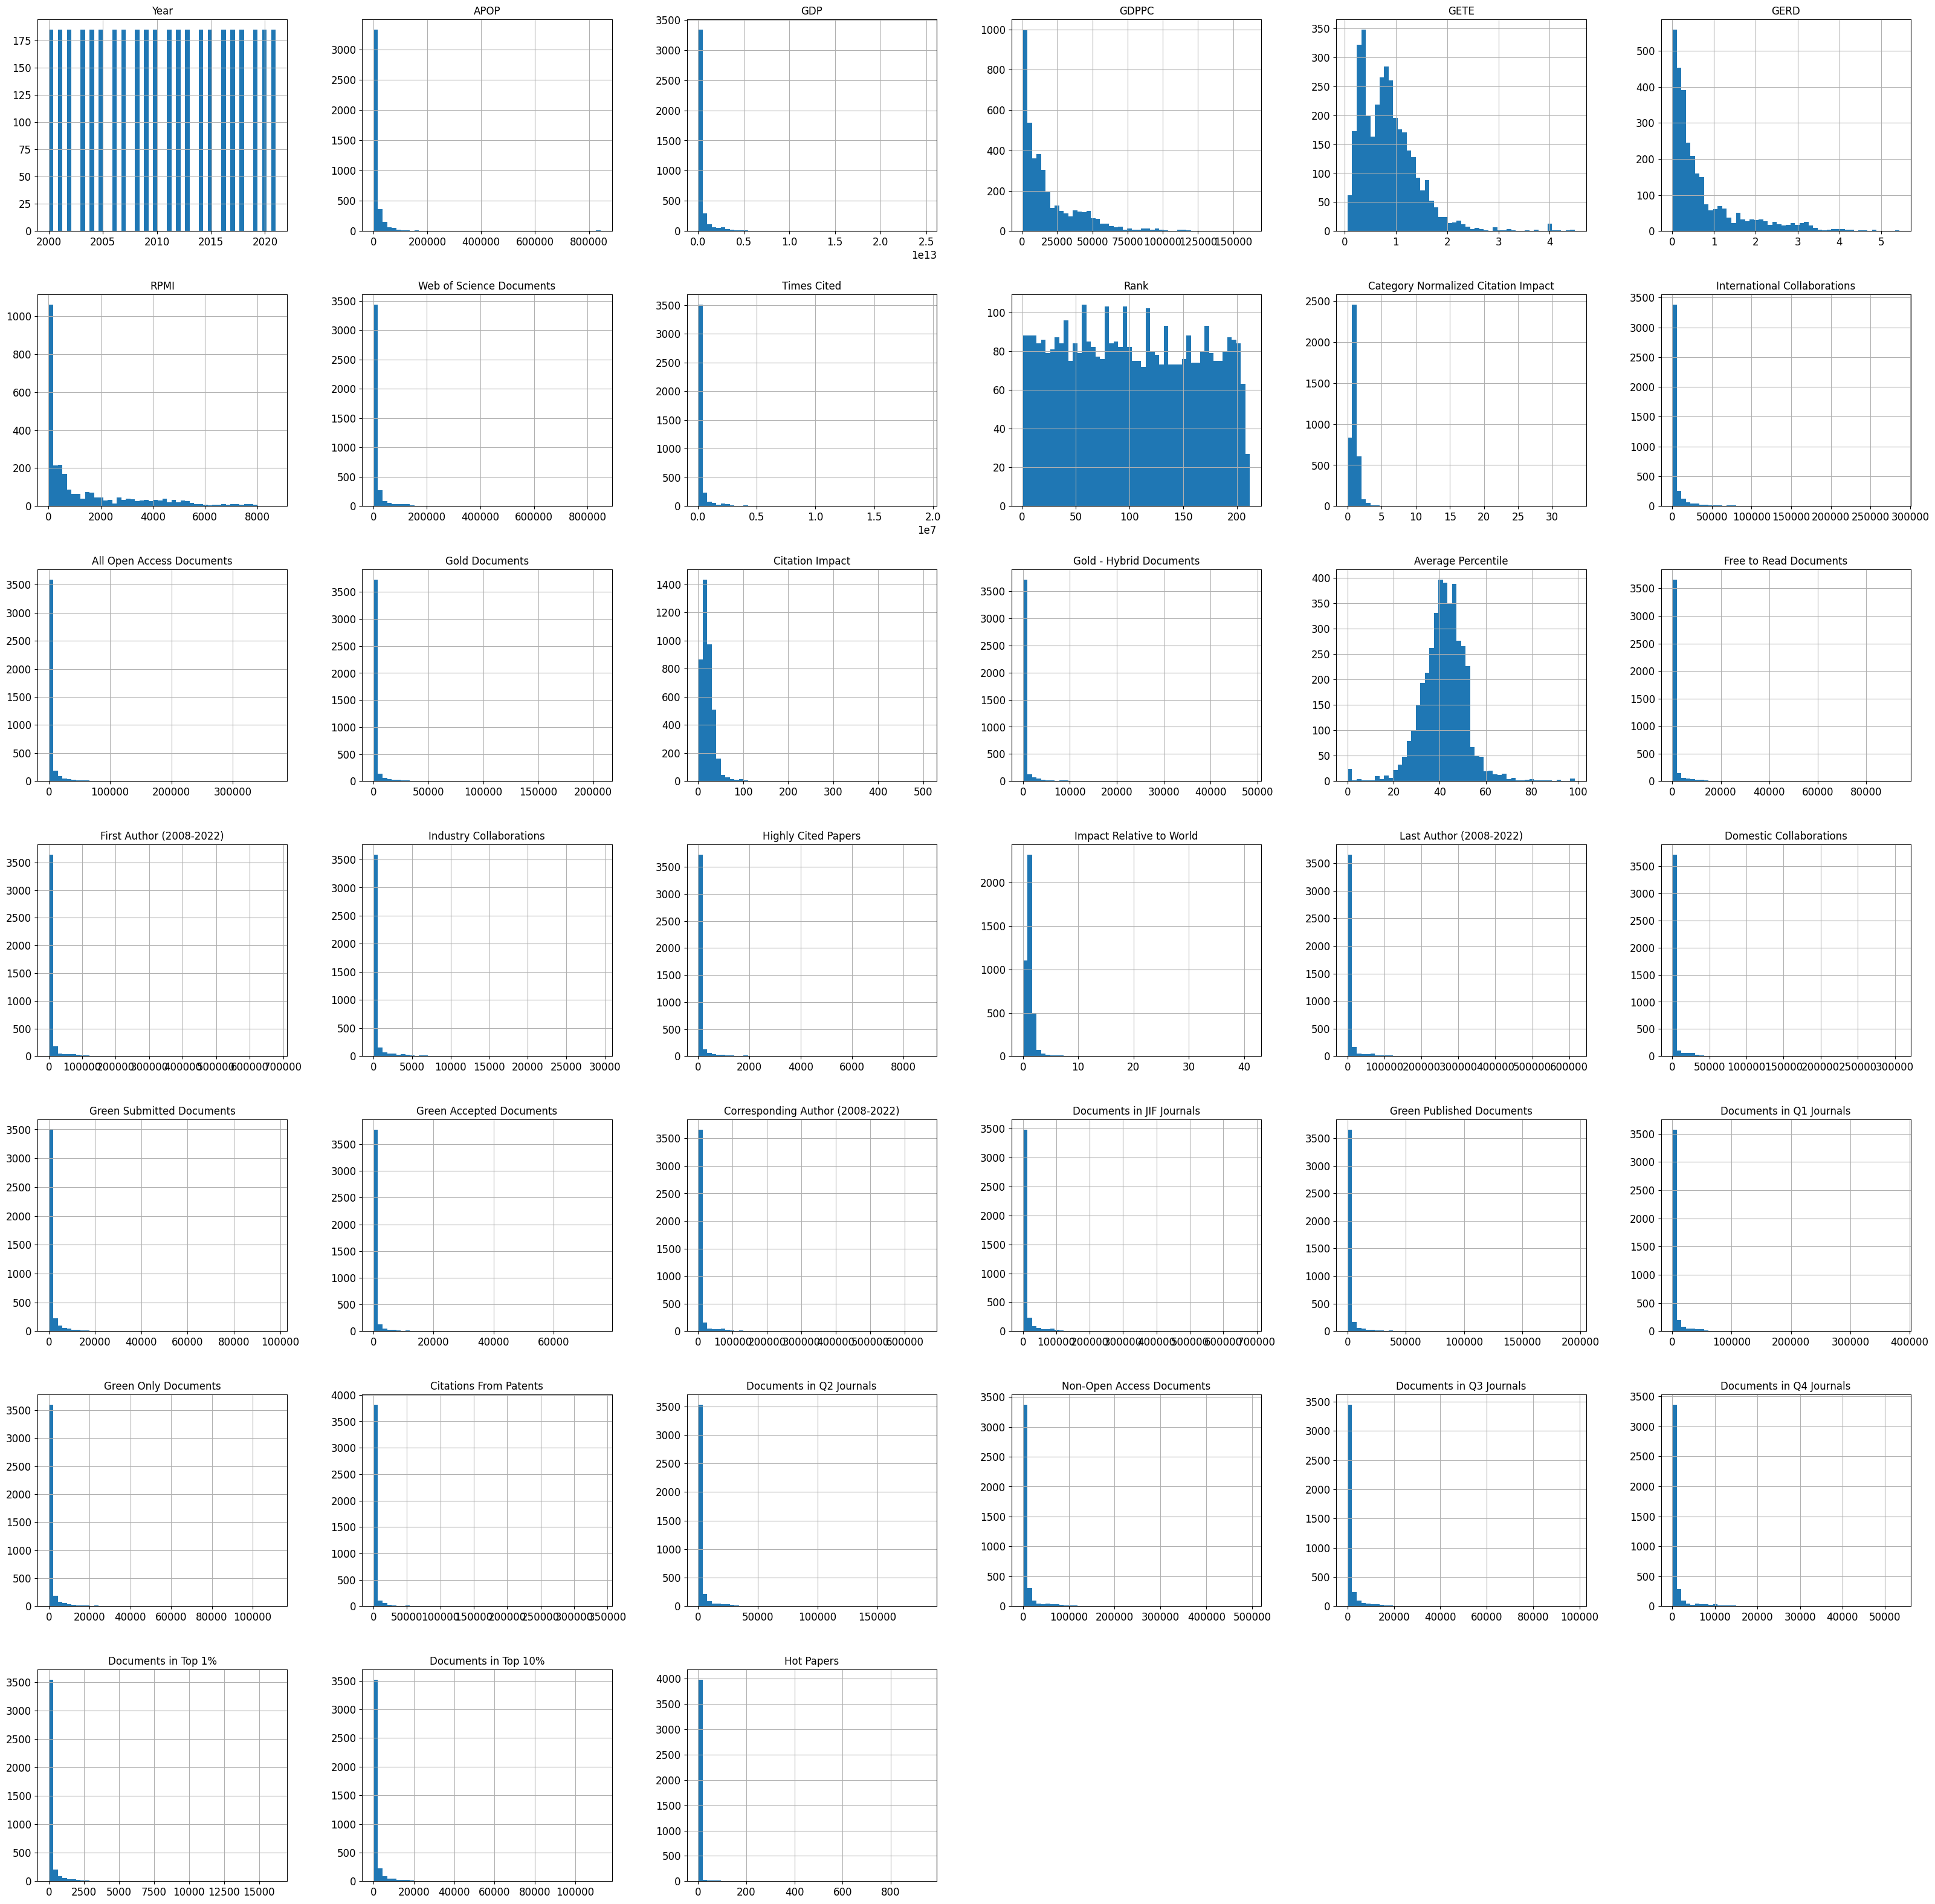

In [134]:
# Plot histograms for each variable, adjusting the number of bins
df.hist(bins=50, figsize=(40,40))
plt.show()

In [135]:
# Drop the column Rank, since the rank is not complete due to countries with missing values that were dropped
df = df.drop(['Rank'], axis=1)

*Line Plot Insights*

The line chart graphs can explain the evolution of the variables over time, comaparing Brazil to rest of the World. Most variables had a crescend trend, with some exceptions, such as those related to the number of citations. It is natural that the number of citations decreases over time, since the recent publications have less time to be cited.

The graphs also show that some of the variables do not present data for all the years, which is a problem for the analysis. Therefore, this variables were removed from the analysis.

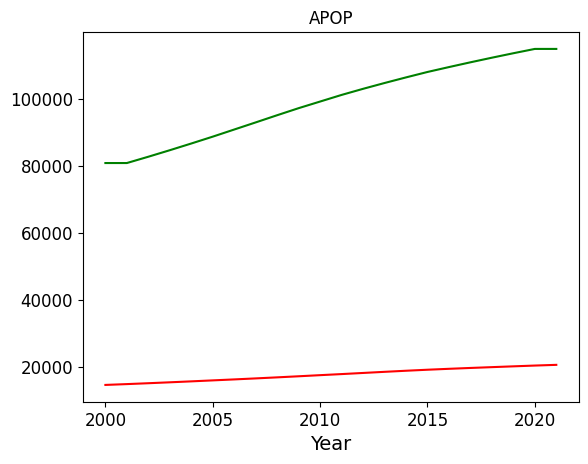

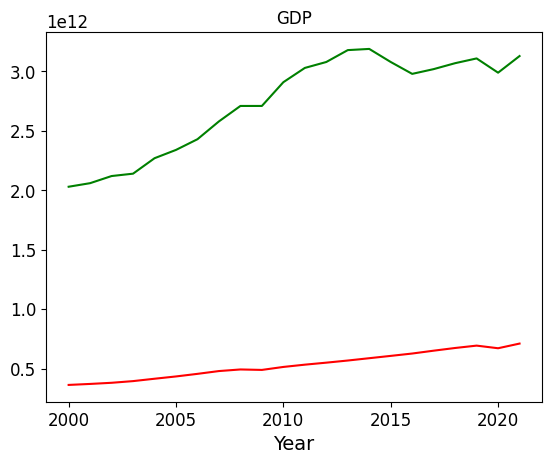

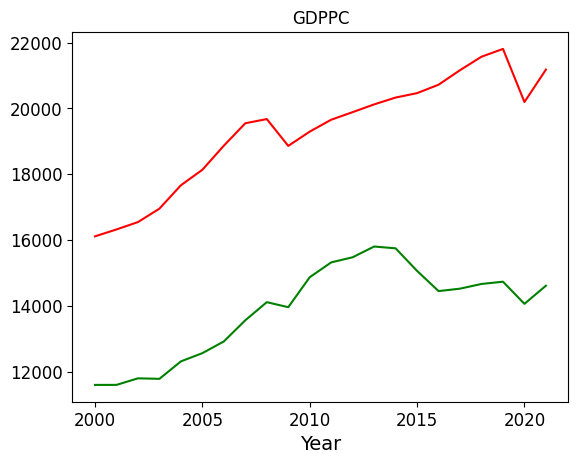

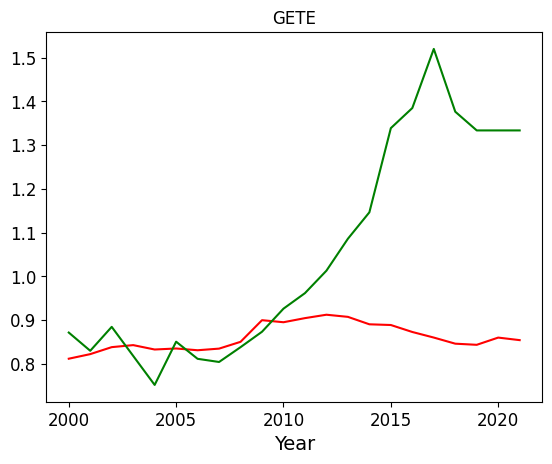

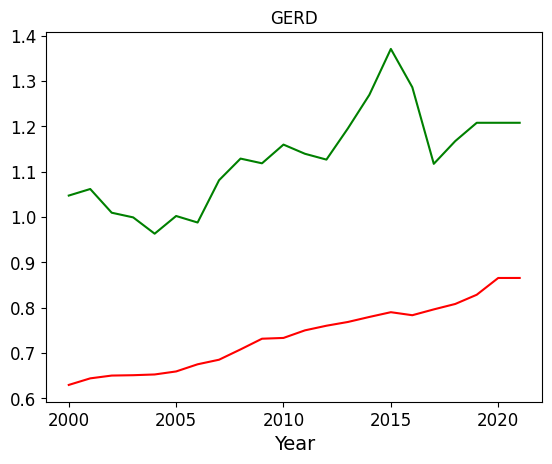

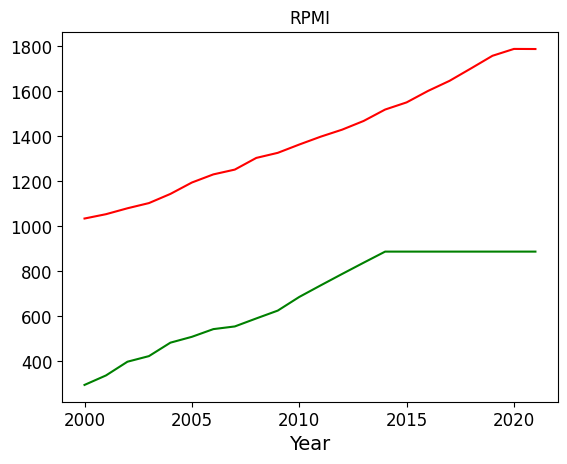

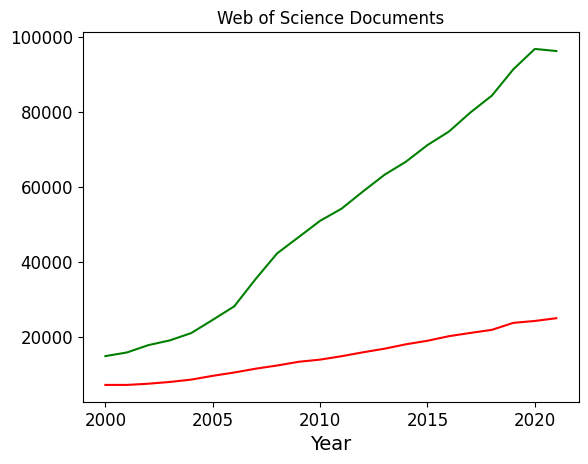

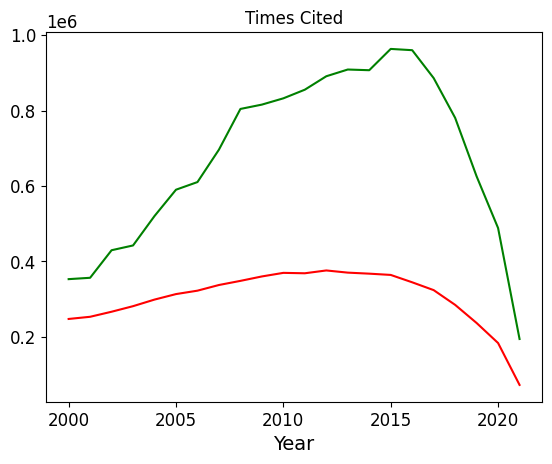

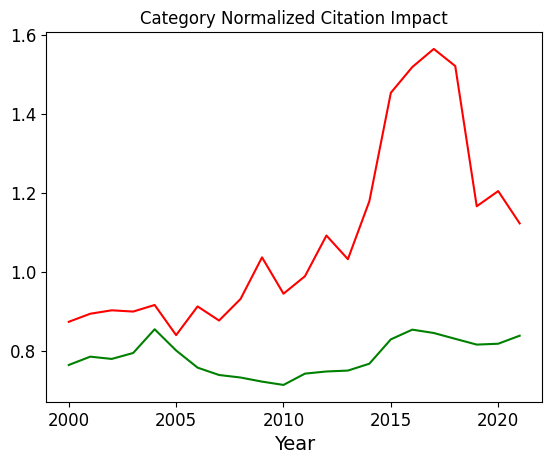

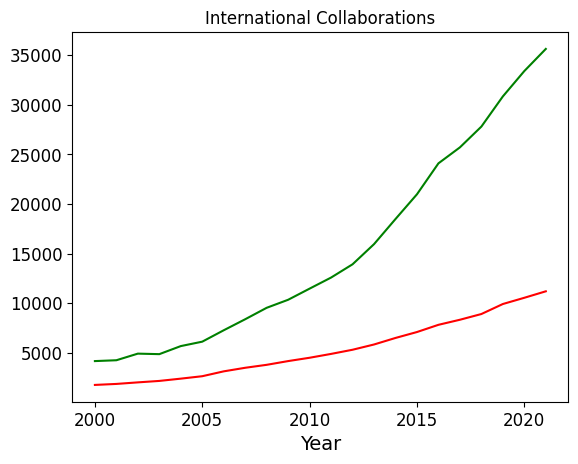

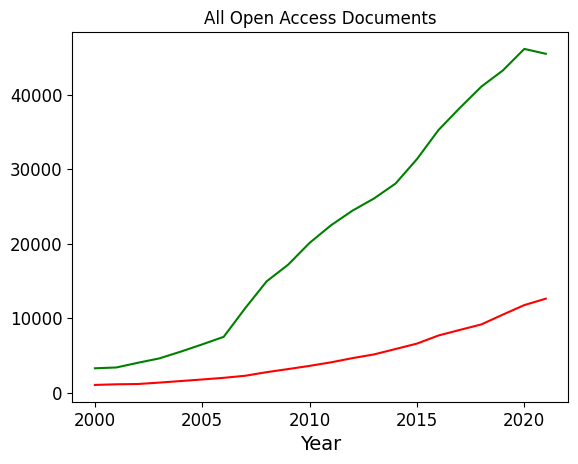

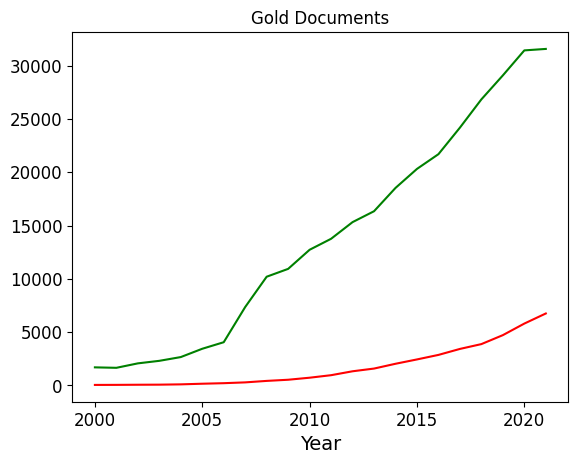

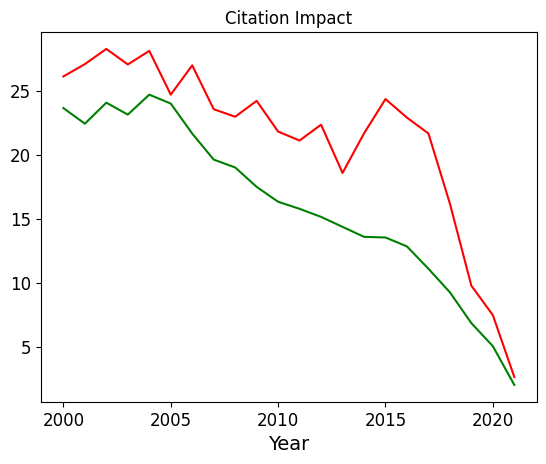

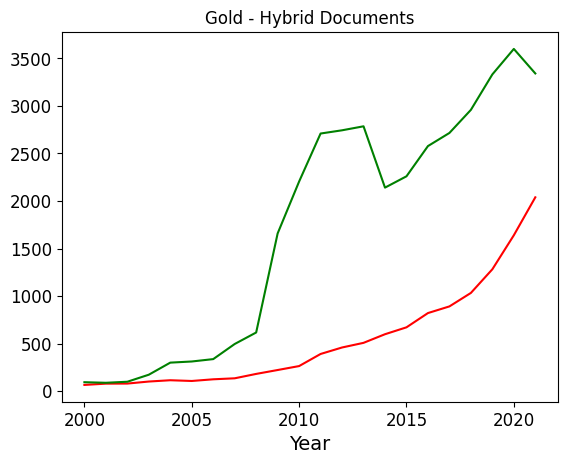

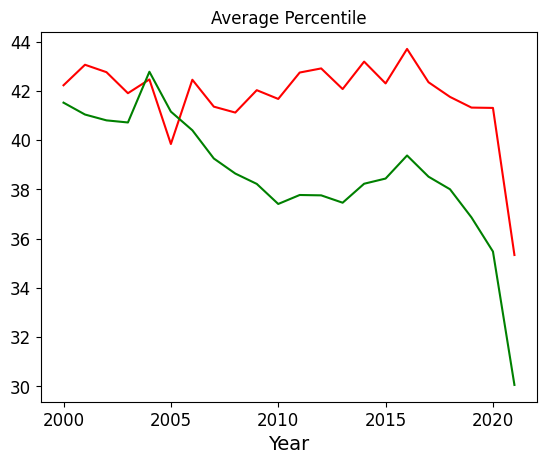

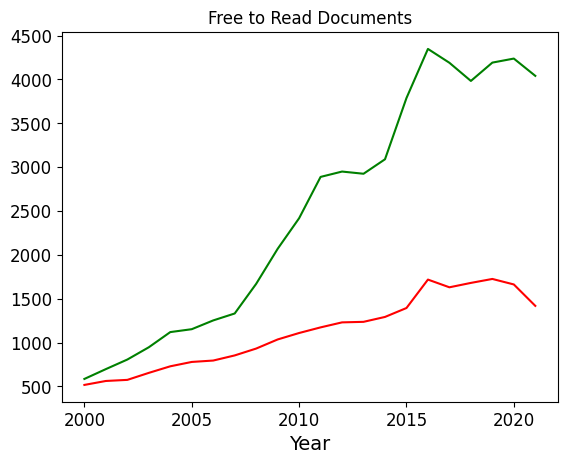

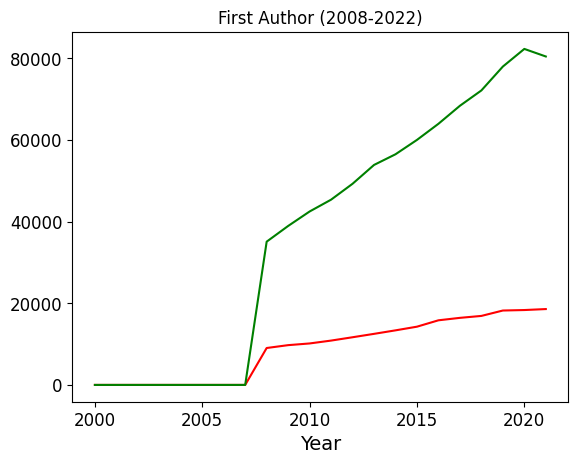

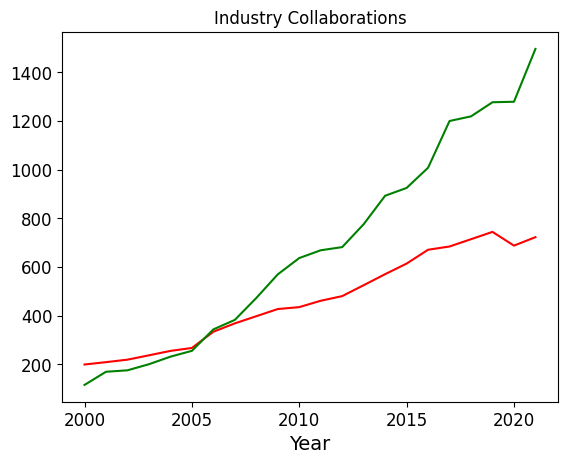

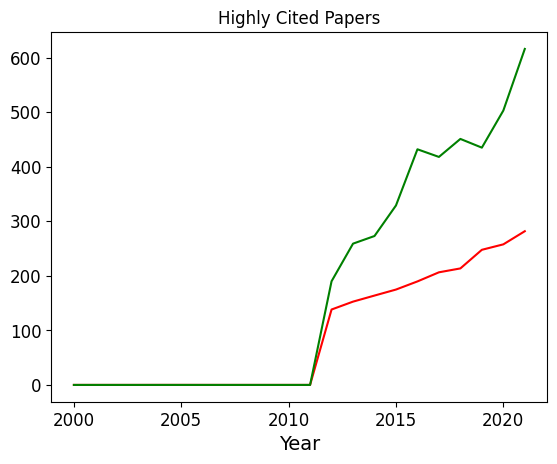

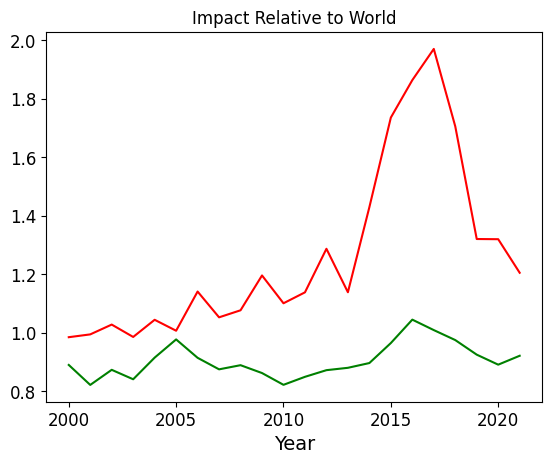

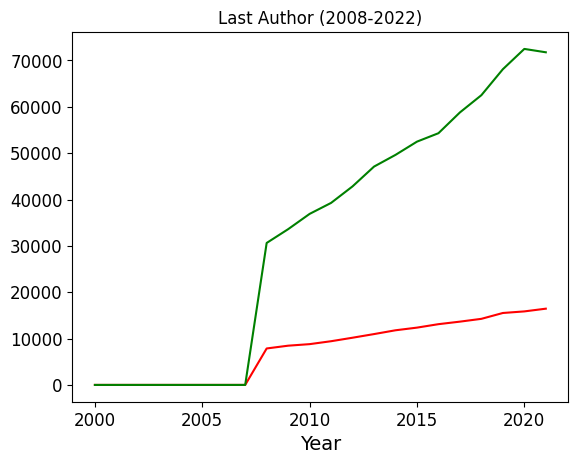

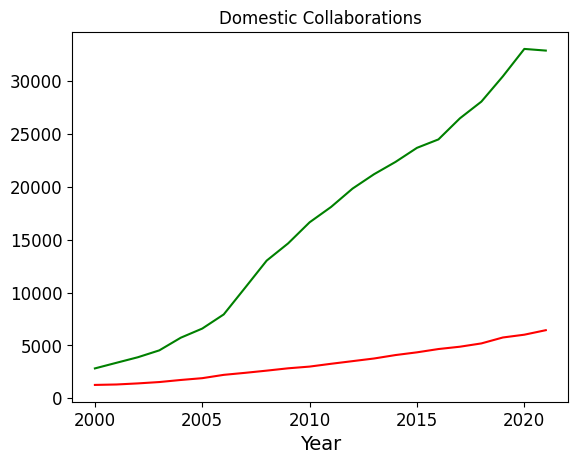

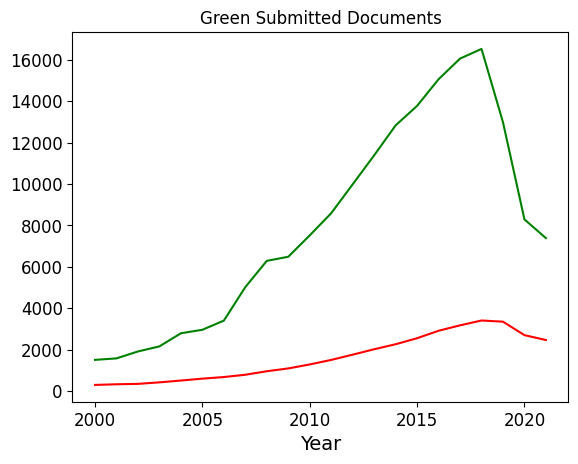

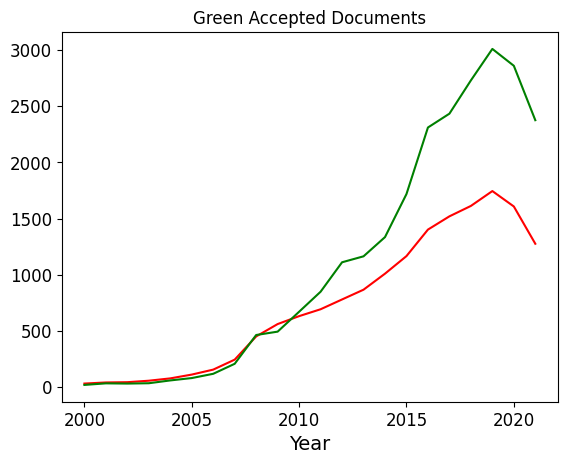

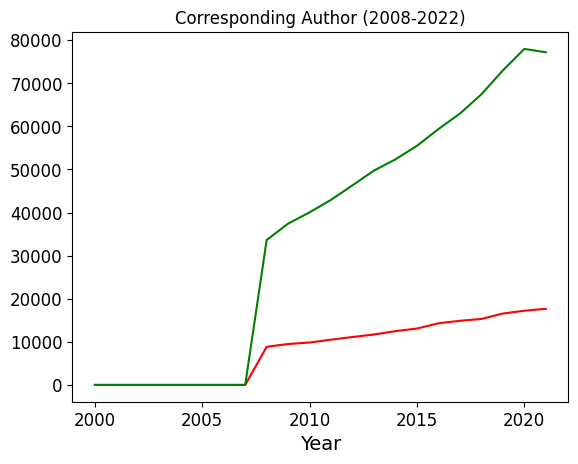

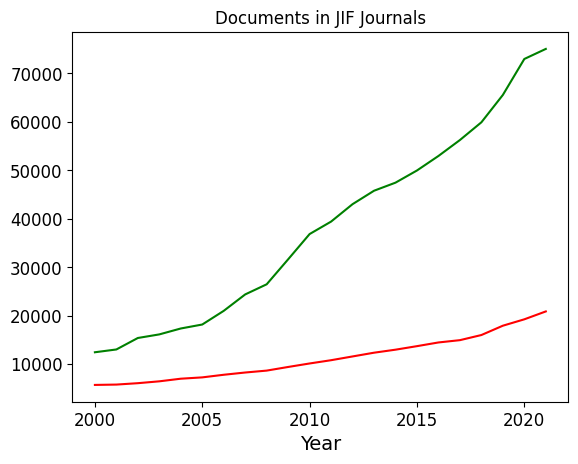

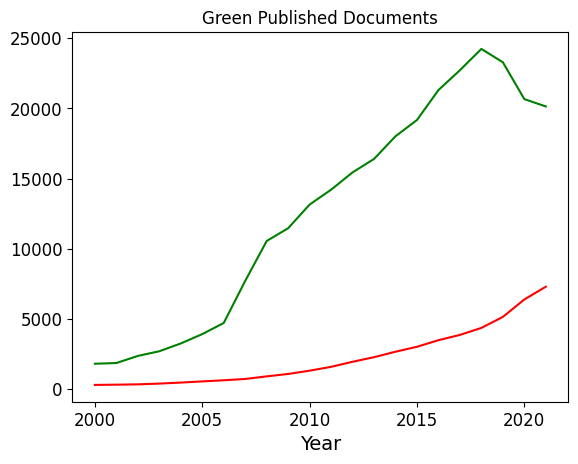

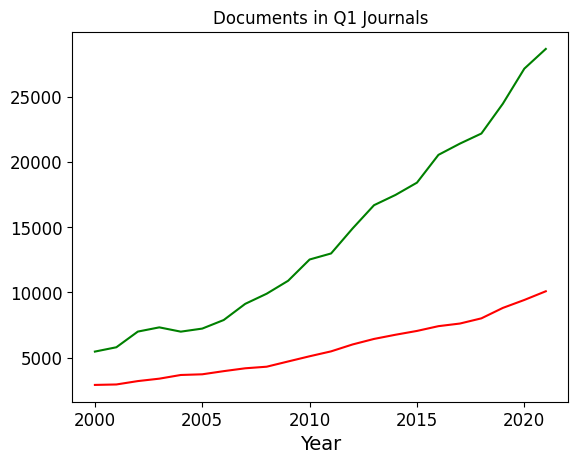

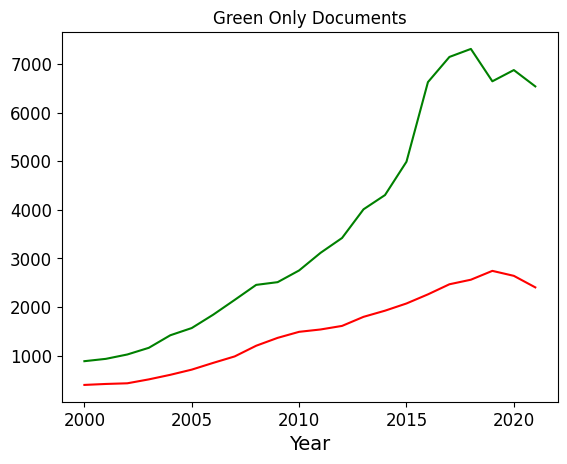

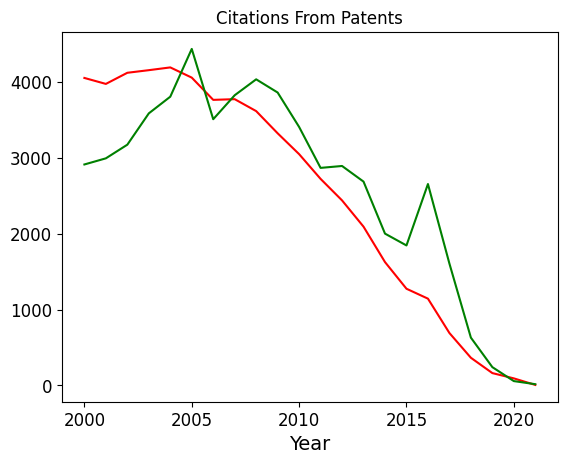

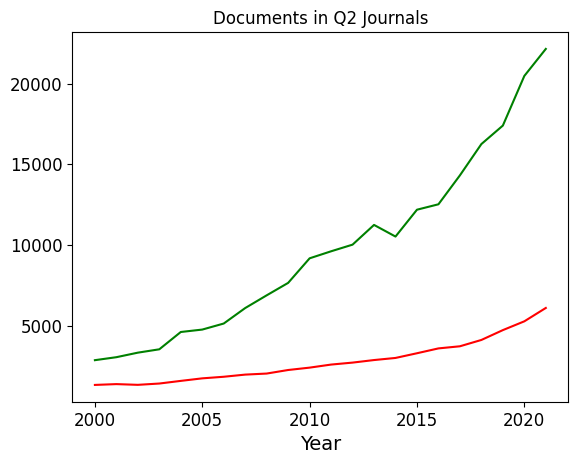

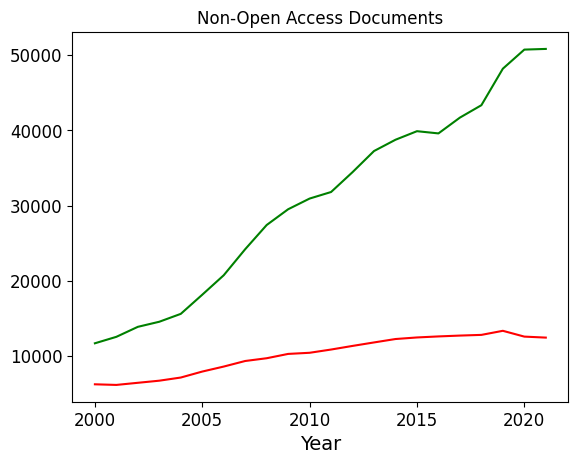

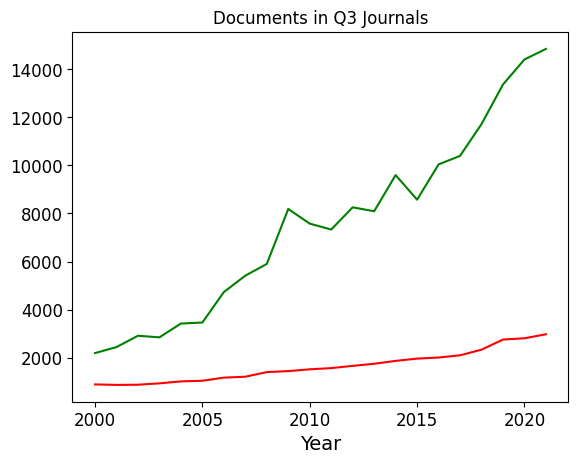

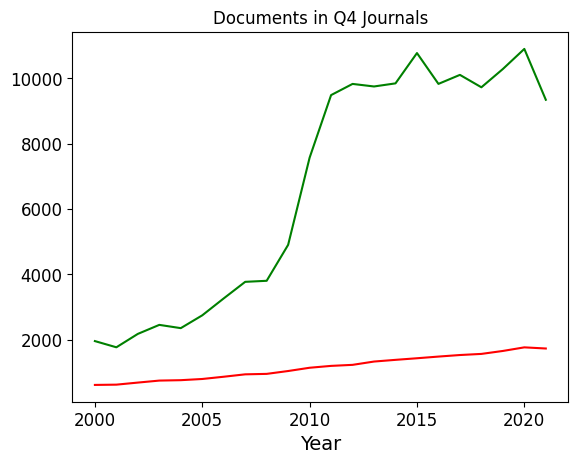

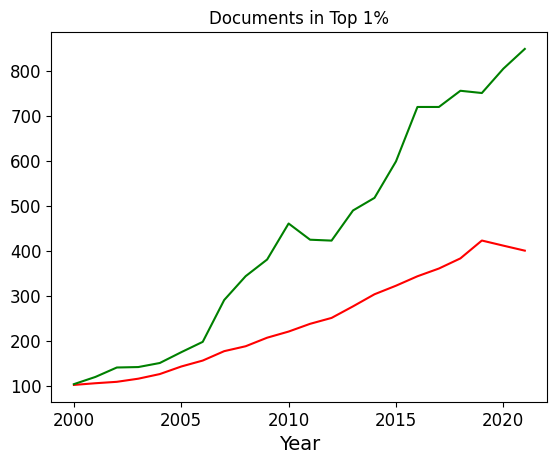

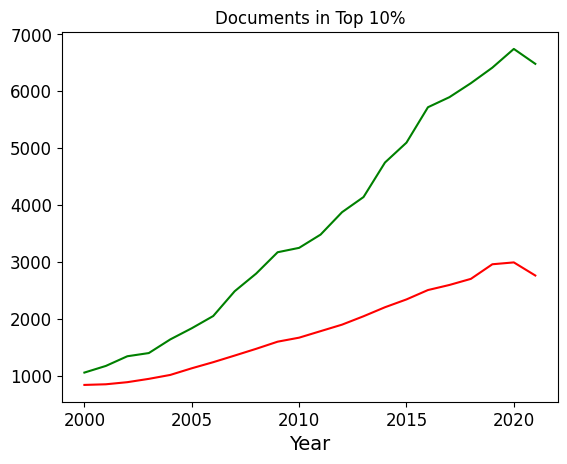

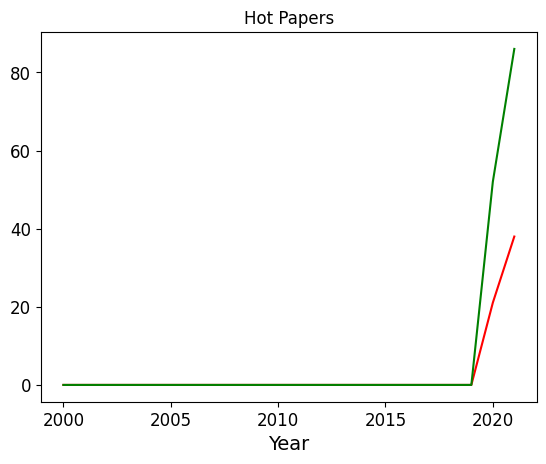

In [136]:
# For each variable after the 5th column, line chart with the valeu of Brazil (in green) vs the World average (in red)
for i in range(5, len(df.columns)):
    df.groupby('Year')[df.columns[i]].mean().plot(color = 'red')
    df[df['Country'] == 'Brazil'].groupby('Year')[df.columns[i]].mean().plot(color = 'green')
    plt.title(df.columns[i])
    plt.show()

In [137]:
# Drop the columns First Author (2008-2022), Last Author (2008-2022), Corresponding Author (2008-2022), Highly Cited Papers and Hot Papers, since they do not have a complete time series  
df = df.drop(['First Author (2008-2022)', 'Last Author (2008-2022)', 'Corresponding Author (2008-2022)', 'Highly Cited Papers', 'Hot Papers'], axis=1)

*Correlation Matrix Insights*

The correlation matrix shows the correlation between the variables. The correlation between the variables is important to understand the relationship between them. Many of the variables are highly correlated, which is expected, since most of them are related to the scientific production.

In [145]:
# Plot a correlation matrix of 5h column onwards with heat map, with two decimal places
corr_matrix = df.iloc[:, 5:].corr()
corr_matrix.style.background_gradient(cmap='PuBuGn').set_precision(2)





C:\Users\rodri\AppData\Local\Temp\ipykernel_18336\1105305053.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix.style.background_gradient(cmap='PuBuGn').set_precision(2)


,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web of Science Documents,Times Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,Gold Documents,Citation Impact,Gold - Hybrid Documents,Average Percentile,Free to Read Documents,Industry Collaborations,Impact Relative to World,Domestic Collaborations,Green Submitted Documents,Green Accepted Documents,Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,Documents in Q4 Journals,Documents in Top 1%,Documents in Top 10%
APOP,1.00,0.71,-0.04,0.05,0.13,-0.02,0.49,0.36,-0.03,0.37,0.38,0.47,-0.04,0.27,-0.03,0.32,0.31,-0.03,0.54,0.35,0.18,0.47,0.37,0.39,0.26,0.20,0.50,0.52,0.58,0.64,0.37,0.41
GDP,0.71,1.00,0.16,0.12,0.36,0.20,0.94,0.81,-0.01,0.82,0.84,0.76,-0.03,0.65,0.00,0.84,0.84,-0.01,0.95,0.79,0.62,0.93,0.79,0.89,0.77,0.60,0.93,0.95,0.95,0.95,0.87,0.89
GDPPC,-0.04,0.16,1.00,0.26,0.51,0.66,0.23,0.24,0.05,0.29,0.23,0.16,0.05,0.24,0.16,0.25,0.28,0.05,0.18,0.26,0.20,0.23,0.23,0.24,0.25,0.17,0.23,0.22,0.21,0.20,0.25,0.25
GETE,0.05,0.12,0.26,1.00,0.36,0.36,0.16,0.15,0.03,0.19,0.16,0.14,0.02,0.16,0.09,0.15,0.17,0.02,0.13,0.17,0.12,0.16,0.16,0.15,0.15,0.10,0.16,0.16,0.16,0.17,0.16,0.16
GERD,0.13,0.36,0.51,0.36,1.00,0.90,0.44,0.41,0.15,0.49,0.42,0.34,0.12,0.40,0.28,0.43,0.50,0.18,0.38,0.45,0.30,0.44,0.41,0.42,0.40,0.30,0.44,0.43,0.44,0.43,0.42,0.43
RPMI,-0.02,0.20,0.66,0.36,0.90,1.00,0.32,0.30,0.14,0.40,0.33,0.24,0.08,0.35,0.24,0.33,0.40,0.19,0.25,0.37,0.26,0.32,0.33,0.32,0.33,0.21,0.32,0.30,0.31,0.29,0.33,0.32
Web of Science Documents,0.49,0.94,0.23,0.16,0.44,0.32,1.00,0.87,0.02,0.95,0.95,0.80,-0.01,0.79,0.05,0.96,0.96,0.01,0.97,0.92,0.80,1.00,0.90,0.99,0.92,0.62,0.99,0.99,0.98,0.92,0.98,0.99
Times Cited,0.36,0.81,0.24,0.15,0.41,0.30,0.87,1.00,0.03,0.75,0.70,0.43,0.05,0.52,0.07,0.85,0.85,0.02,0.78,0.72,0.64,0.85,0.60,0.88,0.79,0.89,0.79,0.92,0.80,0.77,0.88,0.89
Category Normalized Citation Impact,-0.03,-0.01,0.05,0.03,0.15,0.14,0.02,0.03,1.00,0.03,0.03,0.01,0.71,0.03,0.36,0.03,0.03,0.87,0.01,0.03,0.03,0.02,0.03,0.03,0.03,0.02,0.02,0.01,0.01,-0.01,0.03,0.03
International Collaborations,0.37,0.82,0.29,0.19,0.49,0.40,0.95,0.75,0.03,1.00,0.98,0.83,-0.03,0.90,0.07,0.94,0.95,0.03,0.89,0.97,0.86,0.95,0.95,0.94,0.95,0.46,0.95,0.89,0.91,0.85,0.95,0.95


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 4685
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4070 non-null   object 
 1   Code                                 4070 non-null   object 
 2   Region                               4048 non-null   object 
 3   Income Group                         4048 non-null   object 
 4   Year                                 4070 non-null   int64  
 5   APOP                                 4070 non-null   float64
 6   GDP                                  4070 non-null   float64
 7   GDPPC                                4070 non-null   float64
 8   GETE                                 3608 non-null   float64
 9   GERD                                 3036 non-null   float64
 10  RPMI                                 2860 non-null   float64
 11  Web of Science Documents      

## STRATEGY FOR THE RESEARCH

The strategy for this research will involve test the following models:
- Diff in Diff (DID)
- Synthetic Control Method (SCM)
- Synthetic Diff in Diff (SDID)

All of them will be tested and cross-validated through the following steps:
- Split the data into training and test sets
- Train the model with the training set
- Test the model with the test set and evaluate the results
- Cross-validate the model with the test set (using the leave-one-out cross-validation)

(To be continued...)

## DIFF IN DIFF (DID)	

In [ ]:
# Create a Diff in Diff model for Web of Science Documents (dependent variable) and APOP and GDP (independent variable), with Brazil as the treatment country and the rest of the world as the control group, and the year 2006 as the treatment year
model = smf.ols(formula='Q("Web of Science Documents") ~ APOP + GDP + C(Country) + C(Year) + C(Country):C(Year)', data=df[df['Year'] >= 2006])
results = model.fit()
print(results.summary())


                                  OLS Regression Results                                 
Dep. Variable:     Q("Web of Science Documents")   R-squared:                       1.000
Model:                                       OLS   Adj. R-squared:                  1.000
Method:                            Least Squares   F-statistic:                 3.601e+08
Date:                           Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                                   19:18:49   Log-Likelihood:                -19741.
No. Observations:                           2960   AIC:                         3.949e+04
Df Residuals:                               2958   BIC:                         3.950e+04
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                                                   coef    std err          t      P

## SYNTHETIC CONTROL METHOD (SCM)

## SYNTHETIC DIFF IN DIFF (SDID)